# Xgboost Classifier

## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

## Loading the Processed Dataset

In [2]:
data = pd.read_csv("preprocessed.csv")

In [3]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,...,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,...,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,...,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,14.6,8.9,11.0,24.0,13.0,...,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5


In [4]:
data.shape

(145460, 25)

In [5]:
df = data.sample(n = 12000)

In [6]:
df.shape

(12000, 25)

## Dividing the dataset into Independent and Dependent features

In [7]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
y = df["RainTomorrow"]

### Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, stratify = y, random_state = 0)

In [9]:
y_train

26967     0
38336     0
72588     0
23663     1
80966     0
         ..
54768     1
10575     0
47064     0
141958    0
51312     0
Name: RainTomorrow, Length: 9600, dtype: int64

## Handling imbalanced dataset

C:\Users\SWARNAVA\anaconda3\envs\rain\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

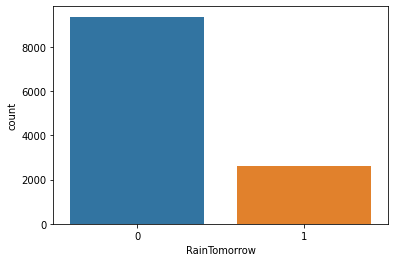

In [10]:
sns.countplot(df["RainTomorrow"])

In [11]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 7494, 1: 2106})
The number of classes after fit Counter({0: 7494, 1: 7494})


### Xgboost Classifier

In [12]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

C:\Users\SWARNAVA\anaconda3\envs\rain\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1738  136]
 [ 236  290]]
0.845
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1874
           1       0.68      0.55      0.61       526

    accuracy                           0.84      2400
   macro avg       0.78      0.74      0.76      2400
weighted avg       0.84      0.84      0.84      2400



0.7393793800292983

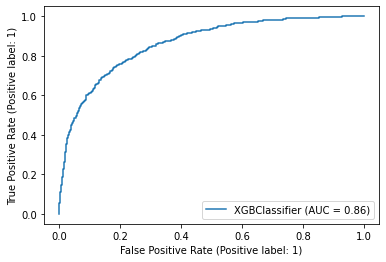

In [14]:
metrics.plot_roc_curve(xgb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred, average=None)

## Hyperparameter Optimization

In [15]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Various learning rate parameters
learning_rate = ['0.05','0.1', '0.2','0.3','0.5','0.6']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
#Subssample parameter values
subsample=[0.7,0.6,0.8]
# Minimum child weight parameters
min_child_weight=[3,4,5,6,7]

In [16]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.05', '0.1', '0.2', '0.3', '0.5', '0.6'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_weight': [3, 4, 5, 6, 7]}


In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
classifier = XGBClassifier()

In [25]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
xg_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=2, random_state=100, n_jobs = -1)

In [26]:
xg_random.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


C:\Users\SWARNAVA\anaconda3\envs\rain\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [27]:
xg_random.best_params_

{'subsample': 0.6,
 'n_estimators': 400,
 'min_child_weight': 5,
 'max_depth': 25,
 'learning_rate': '0.05'}

In [28]:
xg_random.best_score_

0.8415398985855352

In [29]:
from sklearn.metrics import accuracy_score
y_predict = xg_random.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print('Accuracy score {}'.format(accuracy_score(y_test,y_predict)))
print('Classification report {}'.format(classification_report(y_test,y_predict)))

[[1745  129]
 [ 250  276]]
Accuracy score 0.8420833333333333
Classification report               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1874
           1       0.68      0.52      0.59       526

    accuracy                           0.84      2400
   macro avg       0.78      0.73      0.75      2400
weighted avg       0.83      0.84      0.83      2400



## Saving the model to reuse it again

In [30]:
joblib.dump(xgb, "xg_random.pkl")

['xg_random.pkl']